# Semantic smart chunking with Azure OpenAI & Langchain

Semantic Chunking considers the relationships within the text. **It divides the text into meaningful, semantically complete chunks.** 

This approach ensures the information’s integrity during retrieval, leading to a more accurate and contextually appropriate outcome. 

In [1]:
import os
import langchain
import matplotlib.pyplot as plt
import openai
import pytz
import requests
import sys
import time

from dotenv import load_dotenv
from datetime import datetime
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import AzureOpenAIEmbeddings
from openai import AzureOpenAI

In [2]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")
print(f"Langchain version: {langchain.__version__}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
OpenAI version: 1.43.0
Langchain version: 0.2.16


In [3]:
# Local timezone datetime
local_tz = pytz.timezone(requests.get("https://ipinfo.io").json()["timezone"])
now = datetime.now(local_tz).strftime("%d-%b-%Y %H:%M:%S")
print(f"Local time in {local_tz}: {now}")

Local time in Europe/Amsterdam: 06-Sep-2024 10:35:08


## 1. Settings

In [4]:
load_dotenv("azure.env")

# Azure OpenAI
AZURE_OPENAI_ENDPOINT:str = os.getenv("AZURE_OPENAI_API_ENDPOINT")
AZURE_OPENAI_KEY:str = os.getenv("AZURE_OPENAI_API_KEY")

AZURE_OPENAI_VERSION: str = "2024-06-01"
AZURE_OPENAI_TYPE:str = "azure"
MODEL: str = "gpt-4o-2024-08-06"
    
# Embedding model
AZURE_OPENAI_EMBEDDINGS: str = "text-embedding-ada-002"

## 2. Semantic chunking

**Markdown** is a structured and formatted markup language and a popular input for enabling semantic chunking in RAG (Retrieval-Augmented Generation). You can use the Markdown content from the Layout model to split documents based on paragraph boundaries, create specific chunks for tables, and fine-tune your chunking strategy to improve the quality of the generated responses.

This method divides the text into chunks based on **semantic understanding**. Division boundaries are focused on sentence subject and use significant computational algorithmically complex resources. However, it has the distinct advantage of maintaining semantic consistency within each chunk. It's useful for text summarization, sentiment analysis, and document classification tasks.

In [5]:
azure_openai_embeddings = AzureOpenAIEmbeddings(
    azure_deployment=AZURE_OPENAI_EMBEDDINGS,
    openai_api_version=AZURE_OPENAI_VERSION,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    openai_api_type=AZURE_OPENAI_TYPE,
)

In [6]:
text_splitter = SemanticChunker(azure_openai_embeddings)

## 3. Results

In [7]:
DOCS_DIR = "documents"

os.makedirs(DOCS_DIR, exist_ok=True)

In [8]:
document_file = os.path.join(DOCS_DIR, "state.txt")

# Downloading a document
!wget https://github.com/retkowsky/Azure-OpenAI-demos/raw/main/documents/state.txt -O $document_file

--2024-09-06 08:35:08--  https://github.com/retkowsky/Azure-OpenAI-demos/raw/main/documents/state.txt
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/retkowsky/Azure-OpenAI-demos/main/documents/state.txt [following]
--2024-09-06 08:35:09--  https://raw.githubusercontent.com/retkowsky/Azure-OpenAI-demos/main/documents/state.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39027 (38K) [text/plain]
Saving to: ‘documents/state.txt’

documents/state.txt 100%[===================>]  38.11K  --.-KB/s    in 0s      

2024-09-06 08:35:09 (117 MB/s) - ‘documents/state.txt’ saved [39027/39027]



In [9]:
!ls $document_file -lh

-rwxrwxrwx 1 root root 39K Sep  6 08:35 documents/state.txt


In [10]:
with open(os.path.join(DOCS_DIR, "state.txt"), 'r') as file:
    file_content = file.read()

In [11]:
print("Running the semantic chunking...")
start = time.time()

chunks = text_splitter.create_documents([file_content])

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Running the semantic chunking...
Elapsed time = 0 minutes and 4 seconds


In [12]:
print(f"Total number of semantic chunks = {len(chunks)}")

Total number of semantic chunks = 26


### Displaying all the chunks

In [13]:
chunk_size_list = []

for idx, chunk in enumerate(chunks, start=1):
    print(f"********** Chunk {idx} **********\nLength of chunk = {len(chunk.page_content)}\n")
    print(f"\033[1;34m{chunk.page_content}\033[0m\n")
    chunk_size_list.append(len(chunk.page_content))

********** Chunk 1 **********
Length of chunk = 1601

Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans. Last year COVID-19 kept us apart. This year we are finally together again. Tonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. With a duty to one another to the American people to the Constitution. And with an unwavering resolve that freedom will always triumph over tyranny. Six days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world thinking he could make it bend to his menacing ways. But he badly miscalculated. He thought he could roll into Ukraine and the world would roll over. Instead he met a wall of strength he never imagined. He met the Ukrainian people. From President Zelenskyy to every Ukrainian, their fearlessness, their courage, their determination, inspires the world. Groups of citizens bloc

### List of all the chunks with a summary

In [14]:
def gpt_4omini(text):
    """
    Gpt-4o mini model
    """
    client = AzureOpenAI(
        api_key=AZURE_OPENAI_KEY,
        api_version=AZURE_OPENAI_VERSION,
        base_url=f"{AZURE_OPENAI_ENDPOINT}/openai/deployments/{MODEL}",
    )
    
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": "You are an AI helpful assistant. Generate a summary of one line of this text like it was a header of a document."},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": text},
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.5,
    )

    return response

In [15]:
chunk_summary = []

for idx, chunk in enumerate(chunks, start=1):
    chunk_text = chunk.page_content
    print(f"***** Chunk {idx} *****\nLength of chunk = {len(chunk_text)}\n")
    print(f"\033[1;34m{chunk_text}\033[0m\n")
    answer = gpt_4omini(chunk_text)
    chunk_summary.append(answer.choices[0].message.content)
    print("\033[1;32m", end="")
    print(f"Chunk summary: {answer.choices[0].message.content}")
    print("\033[0m")

***** Chunk 1 *****
Length of chunk = 1601

Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans. Last year COVID-19 kept us apart. This year we are finally together again. Tonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. With a duty to one another to the American people to the Constitution. And with an unwavering resolve that freedom will always triumph over tyranny. Six days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world thinking he could make it bend to his menacing ways. But he badly miscalculated. He thought he could roll into Ukraine and the world would roll over. Instead he met a wall of strength he never imagined. He met the Ukrainian people. From President Zelenskyy to every Ukrainian, their fearlessness, their courage, their determination, inspires the world. Groups of citizens blocking tanks

Chunk summary: Standing with Ukraine: Unyielding Spirit and Enduring Bonds

***** Chunk 8 *****
Length of chunk = 1266

He will never weaken the resolve of the free world. We meet tonight in an America that has lived through two of the hardest years this nation has ever faced. The pandemic has been punishing. And so many families are living paycheck to paycheck, struggling to keep up with the rising cost of food, gas, housing, and so much more. I understand. I remember when my Dad had to leave our home in Scranton, Pennsylvania to find work. I grew up in a family where if the price of food went up, you felt it. That’s why one of the first things I did as President was fight to pass the American Rescue Plan. Because people were hurting. We needed to act, and we did. Few pieces of legislation have done more in a critical moment in our history to lift us out of crisis. It fueled our efforts to vaccinate the nation and combat COVID-19. It delivered immediate economic relief for tens of mil

Chunk summary: Building a Better America: A Plan to Fight Inflation by Increasing Productive Capacity and Reducing Costs.

***** Chunk 13 *****
Length of chunk = 602

One in ten Americans has diabetes. In Virginia, I met a 13-year-old boy named Joshua Davis. He and his Dad both have Type 1 diabetes, which means they need insulin every day. Insulin costs about $10 a vial to make. But drug companies charge families like Joshua and his Dad up to 30 times more. I spoke with Joshua’s mom. Imagine what it’s like to look at your child who needs insulin and have no idea how you’re going to pay for it. What it does to your dignity, your ability to look your child in the eye, to be the parent you expect to be. Joshua is here with us tonight. Yesterday was his birthday.

Chunk summary: High Insulin Costs Burden Families: A Personal Story from Virginia

***** Chunk 14 *****
Length of chunk = 207

Happy birthday, buddy. For Joshua, and for the 200,000 other young people with Type 1 diabetes, let’s 

Chunk summary: "Progress Against COVID-19: Moving Towards Normalcy with New Guidelines and Continued Vigilance"

***** Chunk 20 *****
Length of chunk = 6628

Over the past year, we’ve gotten much better at detecting new variants. If necessary, we’ll be able to deploy new vaccines within 100 days instead of many more months or years. And, if Congress provides the funds we need, we’ll have new stockpiles of tests, masks, and pills ready if needed. I cannot promise a new variant won’t come. But I can promise you we’ll do everything within our power to be ready if it does. Third – we can end the shutdown of schools and businesses. We have the tools we need. It’s time for Americans to get back to work and fill our great downtowns again. People working from home can feel safe to begin to return to the office. We’re doing that here in the federal government. The vast majority of federal workers will once again work in person. Our schools are open. Let’s keep it that way. Our kids need to be i

Chunk summary: Advancing Liberty, Justice, and Unity: A Call to Protect Rights, Tackle Health Issues, and Support Veterans.

***** Chunk 22 *****
Length of chunk = 74

Numbness. Dizziness. A cancer that would put them in a flag-draped coffin.

Chunk summary: The Harrowing Journey from Symptoms to Sacrifice.

***** Chunk 23 *****
Length of chunk = 362

I know. One of those soldiers was my son Major Beau Biden. We don’t know for sure if a burn pit was the cause of his brain cancer, or the diseases of so many of our troops. But I’m committed to finding out everything we can. Committed to military families like Danielle Robinson from Ohio. The widow of Sergeant First Class Heath Robinson. He was born a soldier.

Chunk summary: President Biden pledges commitment to investigating military burn pit effects on health, honoring families like the Robinsons.

***** Chunk 24 *****
Length of chunk = 520

Army National Guard. Combat medic in Kosovo and Iraq. Stationed near Baghdad, just yards from b

### List of all the summaries for each chunk

In [16]:
for idx, summary in enumerate(chunk_summary, start=1):
    print(f"Chunk {idx}: {summary}")

Chunk 1: Unity Against Aggression: U.S. Stands with Ukraine in Face of Russian Threats
Chunk 2: NATO's Role and Unity in Response to Rising Global Threats and Putin's Aggression.
Chunk 3: Summary of Actions Taken
Chunk 4: Global Coalition Enforces Sanctions and Support Against Russia's Aggression in Ukraine.
Chunk 5: U.S. Provides Over $1 Billion in Aid to Ukraine, Mobilizes Forces to Defend NATO Allies.
Chunk 6: Global Unity Strengthens Amidst Russia's War on Ukraine, Highlighting Democracy's Resilience.
Chunk 7: Standing with Ukraine: Unyielding Spirit and Enduring Bonds
Chunk 8: "American Rescue Plan: A Lifeline for Struggling Families and Economic Recovery"
Chunk 9: Record Job Creation and Infrastructure Overhaul: Building America's Economic Future
Chunk 10: Intel's Historic $100 Billion Investment Signals American Manufacturing Revival.
Chunk 11: "Major Investments in Electric Vehicles Amid Economic Challenges and Inflation Concerns"
Chunk 12: Building a Better America: A Plan to 

### Semantic chunks size

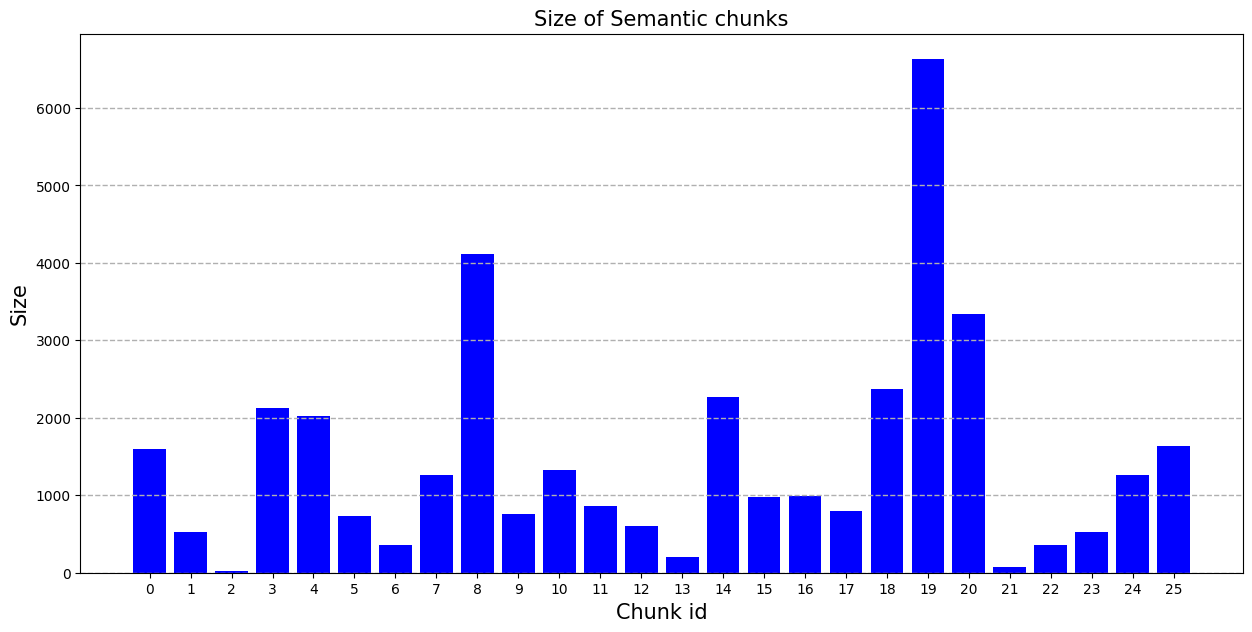

In [17]:
x = range(len(chunk_size_list))
bar_color = 'blue'

plt.figure(figsize=(15, 7))
plt.bar(x, chunk_size_list, color=bar_color)
plt.xlabel('Chunk id', size=15)
plt.ylabel('Size', size=15)
plt.title('Size of Semantic chunks', size=15)
plt.xticks(x)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=1)

plt.show()